<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC2_2020_NB_randomforest_ising2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione stato di un modello di Ising 2D con Random Forests

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Informazioni ###

scopo: imparare ad usare ensamble di modelli deboli tipo foreste random di alberi a decisione binaria 
applicazione: classificazione dello fase in cui si trovano configurazioni d i un modello di Ising 2D
ML tool: cikit-learn


### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

100k configurazioni con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis. 

Il campione è disponibile qui:

* [configurazioni](https://www.dropbox.com/s/ma1n1r2uejb9iei/ising_conf.dat?dl=0)
* [label](https://www.dropbox.com/s/dj1urxh8tsadoh5/ising_label.dat?dl=0)

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

Poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dvideremo il campione in tre sotto-campioni:

* ordinato: $T/J<2.0$
* critico: $2.0\leq T/J\leq 2.5$
* disordinato: $T/J>2.5$

e addestreremo il modello usando solo le configurazioni ordinate e disordinate. Poi testeremo il tutto su tutte le configurazioni.

### Parte 1: load e pre-processamento del dataset ###

In [0]:
import numpy as np

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=28 # size del reticolo
J=1.0 # Ising interaction (1 ferromagnetico, -1 anti-ferromagnetico)
T_c=2.26 # Temperatura critica

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (100k esempi oguno da 28x28 spin)
data = np.loadtxt('/content/drive/My Drive/Colab Notebooks/datasets/ising_conf.dat')
print(data.shape)

(2800000, 28)


NOTA: gli esempi sono scritti nel file come righe sequenziali da 28 valori l'una -> 100k x 28 = 2800000 

In [0]:
# al fine di visualizzare alcune delle configurazioni convertiamo il vettore numpy un tensore di 100K eventi ognuno 
# formato da una matrice 28x28 di spin
data = data.reshape(100000,28,28)
print(data.shape)

(100000, 28, 28)


In [0]:
#esempio
print(data[2]) #stampa 3zo evento una matrice 28x28 di valori dello spin (-1,1)

[[ 1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.
  -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.
   1.  1. -1.  1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1.
   1.  1.  1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1

In [0]:
#leggiamo da file le label associate:
labels = np.loadtxt('/content/drive/My Drive/Colab Notebooks/datasets/ising_label.dat')
print(labels.shape)
print(labels[3]) #temperatura della configurazione del 4to evento

(100000,)
1.66324


In [0]:
# dividiamo il campione in 3 campioni sulla base dello stato (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J > 2.5 disordinato
# altrimenti critico

ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))
    
print(cri_sele)

data_ord = data[ord_sele]
data_dis = data[dis_sele]
data_cri = data[cri_sele]

print(data_ord.shape) 
print(data_cri.shape) 
print(data_dis.shape)   

labels_ord = np.zeros(data_ord.shape[0])
labels_dis = np.ones(data_dis.shape[0])

labels_critic = labels[cri_sele]
print(labels_critic)
labels_cri = labels_critic.copy()
labels_cri[labels_critic>T_c] = 1
labels_cri[labels_critic<=T_c] = 0

print(labels_ord)
print(labels_dis)
print(labels_cri)
print(labels_ord.shape)

[False False  True ... False False False]
(40177, 28, 28)
(9808, 28, 28)
(50015, 28, 28)
[2.46347 2.18529 2.17106 ... 2.40353 2.19896 2.47125]
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[1. 0. 0. ... 1. 0. 1.]
(40177,)


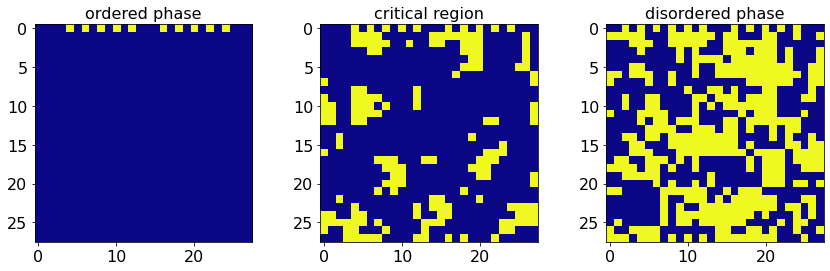

In [0]:
#una rappresentazione grafica più bella
%matplotlib inline 

#import ml_style as style
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data_ord[4],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data_cri[4],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(data_dis[4],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
##Dividiamo il campione per il training
from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

# define training and test data sets
X=np.concatenate((data_ord,data_dis))
Y=np.concatenate((labels_ord,labels_dis))

# selezioniamo random data points dai campioni ordinati e disordinati per cerare training e test
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

X_critical = data_cri
Y_critical = labels_cri

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

# riformattiamo i tensori in modo che abbiano l'input corretto atteso dagli alberi a decisione binaria 
# (vettori flat di features)   (N,28,28) -> (N, 28*28 = 784)

X_train = np.reshape(X_train, (X_train.shape[0], 28*28))
X_test = np.reshape(X_test, (X_test.shape[0], 28*28))
X_critical = np.reshape(X_critical, (X_critical.shape[0], 28*28))

X_train shape: (72153, 28, 28)
Y_train shape: (72153,)

72153 train samples
9808 critical samples
18039 test samples


### Parte 2: addestramento della Random Forests

**Iperparametri**

Usiamo l'implementazione in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) che ha due iperparamteri principali che possono modificare anche sensibimente le prestazioni del modello e il livelo di overfit/underfit: il numero di alberi nella foresta e la complessità di ciascun albero: il primo è controllato dal parametro `n_estimators`, mentre la complesiità è controllata da vari parametri `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc, in parte correlati tra loro. Nell'esempio in esame per semplicità useremo solo `min_samples_split` (governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero.

**NOTA: Stime OOB (Out of Bag)**

È un metodo molto utile per ottimizzare gli iperparametri quanod si usano metodi di bagging: consiste nel verificare quanto bene funziona il classificatore su qyegli eventi del trainign set che non sono stati usati nel training (perchè non campionati nella technica di boostrap). Gioca un ruolo simile alla k-fold cross-validation.

In [0]:
# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier

n_estimator_range=np.arange(min_estimators, max_estimators, 10) #testiamo 10 valori per il primo iperparametro

leaf_size_list=[2,10000] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    )
    for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))


n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.8409         1.0000         0.9912         0.9995         0.8015         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.9906         1.0000         0.9995         0.9994         0.8157         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.3356         1.0000         0.9997         0.9997         0.8129         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.5827         1.0000         0.9997         0.9997         0.8154         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.8983         1.0000         0.9997         0.9994         0.8135         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test scor

In [0]:
print(RFC_train_accuracy)
print(RFC_train_accuracy.shape)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.87423946 0.85490555 0.90452233 0.90692002 0.92159716 0.90991366
  0.90960875 0.90610231 0.9102047  0.91037102]]
(2, 10)


**Grafico delle prestazioni:**

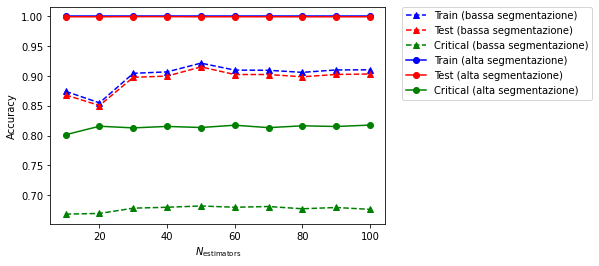

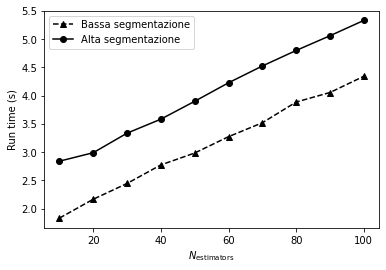

In [0]:
plt.figure()
plt.plot(n_estimator_range,RFC_train_accuracy[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(n_estimator_range,RFC_test_accuracy[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(n_estimator_range,RFC_critical_accuracy[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(n_estimator_range,RFC_train_accuracy[0],'o-b',label='Train (alta segmentazione)')
plt.plot(n_estimator_range,RFC_test_accuracy[0],'o-r',label='Test (alta segmentazione)')
plt.plot(n_estimator_range,RFC_critical_accuracy[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa segmentazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta segmentazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
#plt.savefig("Ising_RF_Runtime.pdf")

plt.show()

### Esercizi: ###  

* provate ad implementare un classificatore basato su un semplice albero di decisione binaria in scikitlearn e confrontare le prestazioni con la foresta random

* provate ad implementare un classificatore tipo gradient boost in scikitlearn 
(*sklearn.ensemble.GradientBoostingClassifier*) ottimizzandone le prestazioni ed evitando overfitting e confrontate con la foresta random

* provate a implementare invece che una validazione OOB (gratis con le foreste random in scikit-learn) una k-fold validation (con k=5 e 10) e verificate se vi sono differenze (OOB tende a dare delle stime molto pessimistiche).
    
NOTA: per imparare ad implementare una k-fold validation in scikit-learn guardate a questo [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)

* (opzionale) provate ad addestrare un modello gradient boost in regressione (*sklearn.ensemble.GradientBoostingRegressor*)che predica le temperature associate alle configurazioni del modello di ising

#**Albero di decisione binaria**

Per prima cosa implementiamo un albero di decisione binaria, utilizzando la funzione apposita disponibile in scikit-learn.

In [0]:
from sklearn.tree import DecisionTreeClassifier

x = 0
n = np.arange(2, 20000, 10000)
for j in n:
  clf = DecisionTreeClassifier(min_samples_leaf=j)
  clf.fit(X_train, Y_train)
  trainscore = clf.score(X_train, Y_train)
  testscore = clf.score(X_test, Y_test)
  criticalscore = clf.score(X_critical, Y_critical)

  print('number of leaves: ', j, 'train accuracy: ', trainscore, ' test accuracy: ', testscore, ' critical accuracy: ', criticalscore)

number of leaves:  2 train accuracy:  0.9993208875583829  test accuracy:  0.9928488275403293  critical accuracy:  0.7084013050570962
number of leaves:  10002 train accuracy:  0.7649162196998046  test accuracy:  0.7576916680525528  critical accuracy:  0.5669861337683524


Osserviamo che, sia usando una alta che una bassa segmentazione, l'accuracy risultante sui tre campioni di training, test e di temperature critiche è minore di quella ottenuta utilizzando la foresta random. Tuttavia, specie nel caso di alta segmentazione, si ottiene una accuracy già elevata per training e test (rispettivamente $99.9\%$ e $99.3\%$), mentre la prestazione veramente deludente riguarda i campioni alle temperature critiche (dove l'accuracy cala dall'$82.3\%$ al $70.4\%$). Si conclude che, per classificare efficacemente campioni ordinati o disordinati, un albero di decisione binaria ad alta segmentazione è più che suffuciente, mentre nel caso di temperature critiche occorre adoperare metodi più sofisticati.

#**Implementazione di GradientBoostingClassifier**

Implementiamo ora l'algoritmo Gradient Boosting Classifier, anch'esso disponibile nella librearia di scikit-learn, e confrontiamone le prestazioni con quelle della random forest.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
gbc_train_accuracy=np.zeros((n,m))
gbc_test_accuracy=np.zeros((n,m))
gbc_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

for i, leaf_size in enumerate(leaf_size_list):
  # Define Gradient Boosting Classifier
  gbc = GradientBoostingClassifier(n_estimators=min_estimators, min_samples_split=leaf_size, random_state=0, warm_start=True)

  for j, n_estimator in enumerate(n_estimator_range):
        
    print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
    start_time = time.time()
    gbc.set_params(n_estimators=n_estimator)
    gbc.fit(X_train, Y_train)
    run_time[i,j] = time.time() - start_time    
    
    # check accuracy
    gbc_train_accuracy[i,j]=gbc.score(X_train,Y_train)
    gbc_test_accuracy[i,j]=gbc.score(X_test,Y_test)
    gbc_critical_accuracy[i,j]=gbc.score(X_critical,Y_critical)
        
    if print_flag:
      result = (run_time[i,j], gbc_train_accuracy[i,j], gbc_test_accuracy[i,j], gbc_critical_accuracy[i,j])
      print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score", "test score", "critical score"))
      print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))


n_estimators: 10, leaf_size: 2
time (s)       train score    test score     critical score 
32.8776        0.8303         0.8275         0.5767         
n_estimators: 20, leaf_size: 2
time (s)       train score    test score     critical score 
33.1774        0.8581         0.8568         0.5854         
n_estimators: 30, leaf_size: 2
time (s)       train score    test score     critical score 
35.2603        0.8942         0.8926         0.6054         
n_estimators: 40, leaf_size: 2
time (s)       train score    test score     critical score 
32.8188        0.9416         0.9400         0.6386         
n_estimators: 50, leaf_size: 2
time (s)       train score    test score     critical score 
32.5343        0.9807         0.9762         0.6764         
n_estimators: 60, leaf_size: 2
time (s)       train score    test score     critical score 
32.7470        0.9900         0.9875         0.7036         
n_estimators: 70, leaf_size: 2
time (s)       train score    test score     critic

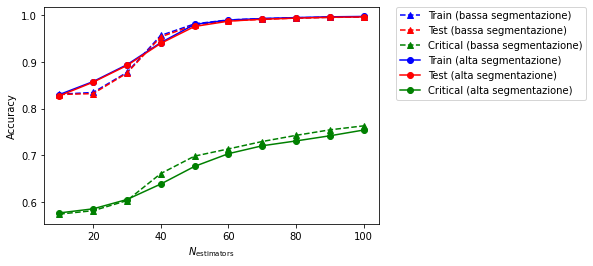

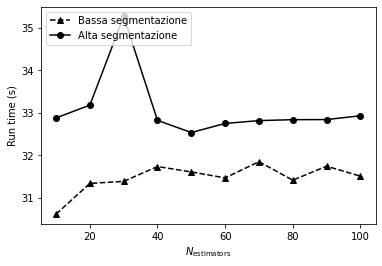

In [0]:
plt.figure()
plt.plot(n_estimator_range,gbc_train_accuracy[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(n_estimator_range,gbc_test_accuracy[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(n_estimator_range,gbc_critical_accuracy[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(n_estimator_range,gbc_train_accuracy[0],'o-b',label='Train (alta segmentazione)')
plt.plot(n_estimator_range,gbc_test_accuracy[0],'o-r',label='Test (alta segmentazione)')
plt.plot(n_estimator_range,gbc_critical_accuracy[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa segmentazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta segmentazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
#plt.savefig("Ising_RF_Runtime.pdf")

plt.show()

Osserviamo che l'algoritmo tende a rendere più simili le dinamiche di alta e bassa segmentazione, per le quali non si osservano ora differenze apprezzabili, una volta saturata l'accuracy per i campioni di training e di test. Per quanto riguarda le temperature critiche, notiamo che l'accuracy migliore è associata alla bassa segmentazione, la quale tuttavia diminuisce dall'$82.3\%$ al $76.3\%$.

Il tempo impiegato dall'algoritmo è però molto maggiore di quello di una random forest. Inoltre, mentre nel caso della foresta esso cresceva linearmente con il numero di stimatori, in questo caso esso appare costante, a meno di fluttuazioni statistiche.

#**Implementazione dell'ADABoost**

Per completare lo studio degli algoritmi di classificazione, implementiamo ADABoost, servendoci ancora della libreria scikit-learn.

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

tree = np.arange(10, 101, 10)
leaf = [2,10000]
m = len(tree)
n = len(leaf)

ada_train_score = np.zeros((n,m))
ada_test_score = np.zeros((n,m))
ada_critical_score = np.zeros((n,m))
run_time = np.zeros((n,m))

for j, l in enumerate(leaf):
  for i, t in enumerate(tree):
    ada = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=l), n_estimators=t)
    start_time = time.time()
    ada.fit(X_train, Y_train)
    ada_train_score[j,i] = ada.score(X_train, Y_train)
    ada_test_score[j,i] = ada.score(X_test, Y_test)
    ada_critical_score[j,i] = ada.score(X_critical, Y_critical)
    run_time[j,i] = time.time() - start_time
    print("\nLeaf size: ", l, "n_estimators: ", t)
    print("Training accuracy: ", ada_train_score[j,i], "Test accuracy: ", ada_test_score[j,i],  "Critical accuracy: ", ada_critical_score[j,i])


Leaf size:  2 n_estimators:  10
Training accuracy:  1.0 Test accuracy:  0.993791230112534 Critical accuracy:  0.6943311582381729

Leaf size:  2 n_estimators:  20
Training accuracy:  1.0 Test accuracy:  0.9933477465491435 Critical accuracy:  0.6956566068515497

Leaf size:  2 n_estimators:  30
Training accuracy:  1.0 Test accuracy:  0.9932368756582959 Critical accuracy:  0.6907626427406199

Leaf size:  2 n_estimators:  40
Training accuracy:  1.0 Test accuracy:  0.9934586174399911 Critical accuracy:  0.6958605220228385

Leaf size:  2 n_estimators:  50
Training accuracy:  1.0 Test accuracy:  0.9931814402128721 Critical accuracy:  0.6897430668841762

Leaf size:  2 n_estimators:  60
Training accuracy:  1.0 Test accuracy:  0.9936803592216863 Critical accuracy:  0.6930057096247961

Leaf size:  2 n_estimators:  70
Training accuracy:  1.0 Test accuracy:  0.9931814402128721 Critical accuracy:  0.6948409461663948

Leaf size:  2 n_estimators:  80
Training accuracy:  1.0 Test accuracy:  0.994234713

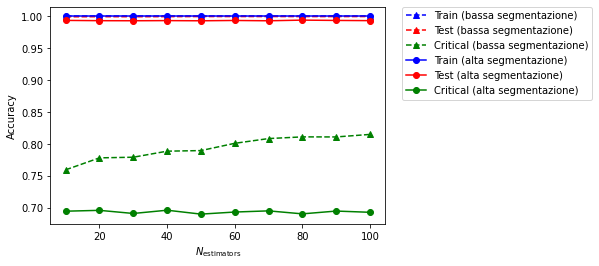

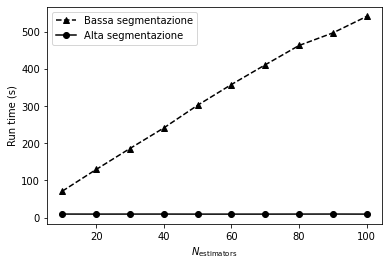

In [0]:
plt.figure()
plt.plot(tree,ada_train_score[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(tree,ada_test_score[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(tree,ada_critical_score[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(tree,ada_train_score[0],'o-b',label='Train (alta segmentazione)')
plt.plot(tree,ada_test_score[0],'o-r',label='Test (alta segmentazione)')
plt.plot(tree,ada_critical_score[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(tree, run_time[1], '--k^',label='Bassa segmentazione')
plt.plot(tree, run_time[0], 'o-k',label='Alta segmentazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
#plt.savefig("Ising_RF_Runtime.pdf")

plt.show()

In questo caso, l'accuracy sul campione di training è massima già con un esiguo numero di stimatori, sia per l'alta, sia per la bassa segmentazione. Osserviamo però un cambio di tendenza nelle performace dei due tipi di segmentazione nei campioni di test e relativi alle temperature critiche. Nel caso del test, sebbene sia alta e bassa segmentazione permettano entrambe all'algoritmo di raggiungere ottimi valori di accuracy, i valori associati alla bassa segmentazione risultano ora costantemente maggiori. Ciò è ancora più evidente nel caso delle temperature critiche: mentre l'alta segmentazione produce dei valori di accuracy abbastanza costanti all'aumentare del numero di stimatori, la bassa segmentazione mostra una leggera crescita, fino a raggiungere l'$81.5\%$ di accuracy (che rimane comunque inferiore a quanto ottenuto con la random forest).

Riscontriamo un'altra peculiarità nel grafico del tempo di run dell'algoritmo: mentre l'alta segmentazione permette all'algoritmo di operare in pochi secondi, indipendentemente dal numero di stimatori, con la bassa segmentazione osserviamo una crescita lineare del tempo di run del programma, che passa da poco più di un minuto per 10 stimatori a quasi 9 minuti per 100 stimatori.

#**Implementazione della K-Fold validation**

Intendiamo ora valutare l'accuracy della random forest mediante la K-fold validation.

In [0]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")
X_critical = data_cri
Y_critical = labels_cri
X_critical = np.reshape(X_critical, (X_critical.shape[0], 28*28))

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier

n_estimator_range=np.arange(min_estimators, max_estimators, 10) #testiamo 10 valori per il primo iperparametro

leaf_size_list=[2,10000] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

#vettori di medie di training, test e critical
Mtra = np.zeros((n,m))
Mtes =np.zeros((n,m))
Critic = np.zeros((n,m))

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True


k=5
kf = KFold(n_splits=k)

for newtrainindex , newtestindex in kf.split(X) :
  #print('TRAIN:', newtrainindex,'TEST:',newtestindex)
  newxtrain,newxtest = X[newtrainindex],X[newtestindex]
  newytrain,newytest = Y[newtrainindex], Y[newtestindex]
  newxtrain = np.reshape(newxtrain, (newxtrain.shape[0], 28*28))
  newxtest = np.reshape(newxtest, (newxtest.shape[0], 28*28))

  for i, leaf_size in enumerate(leaf_size_list):
     # Define Random Forest Classifier
      x=0
      myRF_clf = classifer(
      n_estimators=min_estimators,
      max_depth=None, 
      min_samples_split=leaf_size, # minimum number of sample per leaf
      oob_score=True,
      random_state=0,
      warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
      )
      for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(newxtrain, newytrain)
        run_time[i,j] = time.time() - start_time    
        

    # check accuracy

        RFC_train_accuracy[i,j]=myRF_clf.score(newxtrain,newytrain)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(newxtest,newytest)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        Mtra[i,j] = Mtra[i,j]+RFC_train_accuracy[i,j]
        Mtes[i,j] = Mtes[i,j]+RFC_test_accuracy[i,j]
        Critic[i,j] = Critic[i,j]+RFC_critical_accuracy[i,j]
        
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))

n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.7305         1.0000         0.9913         0.9986         0.7856         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.7169         1.0000         0.9997         0.9986         0.8015         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.9558         1.0000         1.0000         0.9987         0.7991         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.2390         1.0000         1.0000         0.9986         0.8064         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.5139         1.0000         1.0000         0.9983         0.8070         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test scor

In [0]:
print(Mtra)
print(Mtes)
print(Critic)

Mtra=Mtra/k
Mtes=Mtes/k
Critic=Critic/k

print(Mtra)
print(Mtes)
print(Critic)

[[4.99991684 4.99997228 4.99998614 5.         5.         5.
  5.         5.         5.         5.        ]
 [4.6408903  4.58455248 4.65958645 4.66981457 4.6799734  4.67968236
  4.69136571 4.68582201 4.68273139 4.68345208]]
[[4.99772711 4.9984478  4.99850323 4.9984478  4.99817062 4.99850324
  4.99833693 4.9984478  4.99839237 4.99850324]
 [4.3106027  4.30001375 4.32052589 4.32429571 4.32856447 4.32734481
  4.33067109 4.32889703 4.32889706 4.32873073]]
[[3.98440049 4.03976346 4.04394372 4.06311175 4.06137847 4.06678222
  4.06912724 4.07432708 4.08411501 4.0860522 ]
 [3.4019168  3.42822186 3.46339723 3.46553834 3.4805261  3.47920065
  3.48542007 3.49011011 3.49378059 3.49500408]]
[[0.99998337 0.99999446 0.99999723 1.         1.         1.
  1.         1.         1.         1.        ]
 [0.92817806 0.9169105  0.93191729 0.93396291 0.93599468 0.93593647
  0.93827314 0.9371644  0.93654628 0.93669042]]
[[0.99954542 0.99968956 0.99970065 0.99968956 0.99963412 0.99970065
  0.99966739 0.99968956 

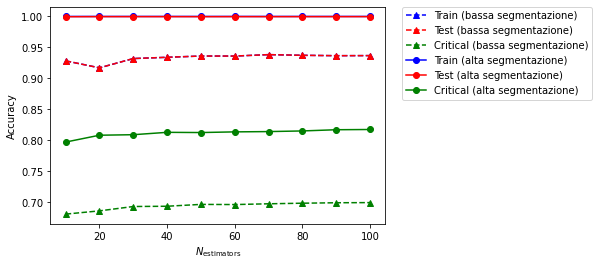

In [0]:
plt.figure()
plt.plot(n_estimator_range,Mtra[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(n_estimator_range,Mtra[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(n_estimator_range,Critic[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(n_estimator_range,Mtra[0],'o-b',label='Train (alta segmentazione)')
plt.plot(n_estimator_range,Mtes[0],'o-r',label='Test (alta segmentazione)')
plt.plot(n_estimator_range,Critic[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()
#plt.savefig("Ising_RF_Runtime.pdf")

Come era lecito aspettarsi, i risultati non differiscono molto da quanto osservato in precedenza. La bassa segmentazione produce i valori di accuracy migliori per il training ed il test già a partire da 40 stimatori (ottenendo come accuracy migliore sul test il $99.97\%$), mentre l'alta segmentazione rimane distante in termini di performance (l'accuracy migliore sul test è in questo caso $86.61\%$). Anche per quanto riguarda i campioni relativi alle temperature critiche si conferma la tendenza già osservata: l'alta segmentazione produce un'accuracy massima dell'$81.72\%$, mentre la bassa segmentazione si ferma al $69.90\%$.

#**Gradient Boosting Regressor**

Infine, dedichiamoci all'addestramento di un regressore di tipo Gradient Boost in grado di predire le temperature associate alle varie configurazioni degli spin.

In [0]:
# dividiamo il campione in 3 campioni sulla base dello stato (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J > 2.5 disordinato
# altrimenti critico

ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))
lab_dis = []
lab_ord = []
lab_crit =[]
for d in labels:
  if d < 2 :
    lab_ord.append(d)
  if d > 2.5 :
    lab_dis.append(d)
  else :
    lab_crit.append(d)

In [0]:
lab_ord = np.array(lab_ord)
lab_dis = np.array(lab_dis)
lab_crit = np.array(lab_crit)
#print(ord.shape)
#print(labels_ord.shape)

In [0]:
#creiamo i campioni di training, di test e delle temperature critiche

from sklearn.model_selection import train_test_split
train_to_test_ratio = 0.8
X_gbr=np.concatenate((data_ord,data_dis))
Y_gbr=np.concatenate((lab_ord,lab_dis))
X_traingbr,X_testgbr,Y_traingbr,Y_testgbr=train_test_split(X_gbr,Y_gbr,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
X_critgbr = data_cri
Y_critgbr = lab_crit
X_traingbr = np.reshape(X_traingbr, (X_traingbr.shape[0], 28*28))
X_testgbr = np.reshape(X_testgbr, (X_testgbr.shape[0], 28*28))
X_critgbr = np.reshape(X_critgbr, (X_critgbr.shape[0], 28*28))

In [0]:
#addestriamo l'algoritmo

from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(X_traingbr,Y_traingbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
#stampiamo una temperatura predetta e confrontiamola con quella vera

#import sys
#np.set_printoptions(threshold=sys.maxsize)
#print(X_test.shape)
print("\n")
print(gbr.predict(X_testgbr)[1])
print(Y_testgbr[1])



4.489519339119534
4.85858


Osserviamo che, nell'esempio in esame, la temperatura predetta è prossima a quella vera. Tuttavia, la differenza tra i due valori non è tale da promuovere la capacità di predizione dell'algoritmo: l'errore è infatti del $7.6\%$, mentre ci aspetteremmo che un algoritmo perfettamente funzionante riesca a produrre risultati con un errore ben minore.

Per esaminare più a fondo la questione, calcoliamo l'accuracy dell'algoritmo. Essendo la temperatura una grandezza con valori nel continuo, occorrerà stabilire un valore di soglia $\epsilon$ per la differenza tra la temperatura predetta e quella vera entro il quale consideriamo due valori compatibili. Dall'esempio mostrato sopra, risulta chiaro che l'errore commesso dall'algoritmo sia piuttosto alto. Dovremo pertanto considerare valori di $\epsilon$ non troppo piccoli.

In [0]:
#Calcoliamo le accuracy

eps = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2]

gbr_pred_train = gbr.predict(X_traingbr)
gbr_pred_test = gbr.predict(X_testgbr)
gbr_pred_crit = gbr.predict(X_critgbr)

print(gbr_pred_train.shape)
print(gbr_pred_test.shape)
print(gbr_pred_crit.shape)

(72153,)
(18039,)
(9808,)


In [0]:
gbr_acc_train = 0
gbr_acc_test = 0
gbr_acc_crit = 0

for epsilon in eps:
  for i in range(0,72153,1):
    if abs(gbr_pred_train[i]-Y_traingbr[i]) < epsilon:
      gbr_acc_train += 1

  gbr_acc_train /= 72153

  for i in range(0,18039,1):
    if abs(gbr_pred_test[i]-Y_testgbr[i]) < epsilon:
      gbr_acc_test += 1

  gbr_acc_test /= 18039

  for i in range(0,9808,1):
    if abs(gbr_pred_crit[i]-Y_critgbr[i]) < epsilon:
      gbr_acc_crit += 1

  gbr_acc_crit /= 9808

  print('Tolerance: %g'%epsilon)
  print("Accuracy on the train set: %.4f"%gbr_acc_train)
  print("Accuracy on the test set: %.4f"%gbr_acc_test)
  print("Accuracy on the critical set: %.4f"%gbr_acc_crit)
  print('\n')

Tolerance: 0.0001
Accuracy on the train set: 0.0001
Accuracy on the test set: 0.0000
Accuracy on the critical set: 0.0001


Tolerance: 0.001
Accuracy on the train set: 0.0012
Accuracy on the test set: 0.0008
Accuracy on the critical set: 0.0002


Tolerance: 0.01
Accuracy on the train set: 0.0116
Accuracy on the test set: 0.0108
Accuracy on the critical set: 0.0038


Tolerance: 0.1
Accuracy on the train set: 0.1186
Accuracy on the test set: 0.1165
Accuracy on the critical set: 0.0435


Tolerance: 0.5
Accuracy on the train set: 0.5776
Accuracy on the test set: 0.5697
Accuracy on the critical set: 0.2126


Tolerance: 1
Accuracy on the train set: 0.9116
Accuracy on the test set: 0.9033
Accuracy on the critical set: 0.4148


Tolerance: 2
Accuracy on the train set: 0.9981
Accuracy on the test set: 0.9976
Accuracy on the critical set: 0.7737




Come era prevedibile, i valori dell'accuracy sono molto bassi per degli $\epsilon$ comunque elevati, rispetto alla variazione massima desiderata nel determinare una temperatura. Osserviamo che solo ammettendo una differenza massima di 0.5 tra predizione e misura l'accuracy sui campioni di training e di test supera il $50\%$, mentre per ottenere un'accuracy almeno del $90\%$ sugli stessi campioni è necessario spingersi a $\epsilon=1$. Per quanto riguarda i campioni relativi a temperature critiche, si ottiene un buon valore di accuracy solo per $\epsilon=2$. Avendo però stabilito come range delle temperature critiche [2, 2.5], non possiamo che considerare inconcludente qualsiasi analisi eseguita con una tolleranza così elevata.